# Investigation of Optimal Strategy of Deal or No Deal

### Introduction

The game show, Deal or No Deal, offers a fun setting to explore optimal stopping strategies in a competitive enviroment.

The goal of this project is to understand the tradeoffs among different strategies, as well as to suggest optimal strategies, both for the Banker and the Contestant.

We will use stochastic approximation to estimate the expected value of different objective functions.

### Game Rules

The game particpants are a contestant and the banker.

The rules of the game are as follows:

- **There are 26 briefcases of cash, each numbered 1-26**


- **The briefcases hold different cash amounts, ranging from \\$0.01 to \\$1,000,000**


- **At the start of the game, the contestant will select one briefcase among the 26 and place it aside**


- **There are 9 rounds of play** 


- **In rounds 1-9, the Contestant eliminates 6, 5, 4, 3, 2, 1, 1, 1, 1 suitcases from game play, respectively (i.e., in round 1, he eliminates 6 suitcases; in round 2, 5 suitcases, and so on)**


- **At the end of each round, the Banker makes a cash offer to the Contestant to buy his suitcase**


- **If the Contestant rejects each offer after 9 rounds, the Contestant then chooses between the remaining two suitcases, and receives that reward**

### Game Model

Simulating the game consists of modeling three main components:


1. **The Banker's offer function**

We use a statistical model to emulate the Banker's offer function based upon the following article: Atlantic Electronic, Journal of Mathematics, Volume 4, Number 1, Winter 2010
[Statistical Models for the Banker's Offer in Deal or No Deal, by David Ritcey and Pritam Ranjan.](http://www.acadiau.ca/~pranjan/research/Ritcey_Ranjan.pdf).

2. **The Player's Actions**

Each round the player selects some number of suitcases to have removed. And at the end of each round, the player must decide whether to take the Banker's offer or continue to play the game.

We create two strategies for the player. The first is a zero-intelligence strategy where the player randomly chooses a round at which to stop playing and accept whatever offer stands. The other is the strategy given by solving for the policy function via the Bellman equation for optimal stopping. This strategy provides the player a rule, round by round, that dictates whether to continue playing or take the current offer. The optimal stopping strategy is designed to maximize the player's utility of the player's winnings.

3. **Assignment and Updating of Reward Suitcases**

Bookkeeping the changes to the environment.


#### Import required libraries for modeling

In [1]:
from __future__ import print_function
from matplotlib import pyplot as plt
import matplotlib.ticker as plticker
import seaborn as sns
import scipy
# import scikits.bootstrap as bootstrap
import pandas as pd
import numpy as np
import random
import warnings
import time
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
warnings.simplefilter(action='ignore', category=FutureWarning)

from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

plt.rcParams['figure.figsize'] = [12, 10]

#### Read in Game Data nd Banker-Offer Data

In [2]:
gameData = pd.read_csv('dealOrNoDeal.csv')
bankerOfferRule = pd.read_csv('bankerOfferData.csv')

In [3]:
gameData

,Reward,State
0,$0.01,1
1,$1,1
2,$5,1
3,$10,1
4,$25,1
5,$50,1
6,$75,1
7,$100,1
8,$200,1
9,$300,1


In [4]:
bankerOfferRule

,round,LCB,P_i,UCB,S_i
0,1,6.05,17.01,38.92,8.2175
1,2,11.61,27.29,55.70,11.0225
2,3,22.74,40.24,62.00,9.8150
3,4,26.00,50.88,78.92,13.2300
4,5,36.30,60.16,91.19,13.7225
5,6,47.82,70.52,97.68,12.4650
6,7,40.44,80.83,109.52,17.2700
7,8,47.09,92.77,114.75,16.9150
8,9,48.85,95.64,108.91,15.0150


### Deal or No Deal Analysis Class

To make the simulation and analysis of the game tractable, we create a DealorNoDeal class that will contain all required attributes and methods to explore and analyze optimal strategies.

In [5]:
# -*- coding: utf-8 -*-
"""
@author: James
"""

class DealOrNoDeal(object):
    """Class for simulating and analyzing DealOrNoDeal game
    
     Attributes:
        bankerOfferRule: A dataframe detailing the parameter estimates for the Banker's
                         offer in each round
    """


    def __init__(self,nscen,gamma,verbose):
        # Load data
        gameData = pd.read_csv('dealOrNoDeal.csv')
        bankerOfferRule = pd.read_csv('bankerOfferData.csv')
        
        # Clean game data
        clean1 =  gameData.iloc[:,0].str.replace('$','').astype(str)
        gameData.iloc[:,0] = clean1
        clean2 = gameData.iloc[:,0].str.replace(',','').astype(float)
        gameData.iloc[:,0] = clean2
        
        # Clean bankerOfferRule data
        bankerOfferRule = pd.DataFrame([bankerOfferRule['P_i'],bankerOfferRule['S_i']])
        bankerOfferRule = bankerOfferRule.transpose()
        boxesAvailr1r9 = list(np.linspace(1,26,26))
        
        # Set attributes
        self.gameData = gameData
        self.bankerOfferRule = bankerOfferRule
        self.boxesAvailr1r9 = boxesAvailr1r9
        self.nscen = nscen
        self.isSim = 0
        self.verbose = verbose
        self.offers = 10
        if gamma < 0:
            raise Exception("gamma must be non-negative")
        else:
            self.gamma  = gamma
        
    def resetGameData(self):
        gameData = pd.read_csv('dealOrNoDeal.csv')    
        # Clean game data
        clean1 =  gameData.iloc[:,0].str.replace('$','').astype(str)
        gameData.iloc[:,0] = clean1
        clean2 = gameData.iloc[:,0].str.replace(',','').astype(float)
        gameData.iloc[:,0] = clean2

        boxesAvailr1r9 = list(np.linspace(1,26,26))
        
        self.gameData = gameData
        self.boxesAvailr1r9 = boxesAvailr1r9

        
    def simulateGames(self):
        # Set number of rounds/offers and number of games to simulate
        
        games = self.nscen
        
        # Initialize containers to store results
        self.expectedValueAtOffer = pd.DataFrame(np.zeros([games,self.offers]))
        self.offersData = pd.DataFrame(np.zeros([games,self.offers]))
    
        for gameCounter in range(games):
            self.resetGameData()
            self.nineRoundGame(gameCounter)
        self.isSim = 1
        
            
    def nineRoundGame(self,gameCounter):
        self.rewardToBoxAssign()
        self.playersBox()
        for rd in range(1,11):
            self.playerChoose(rd)
            self.expectedValueAtOffer[gameCounter,rd-1] = self.expectedValue()
            if rd < 10:
                self.offersData.iloc[gameCounter,rd-1] = self.bankerOffer(rd)
            else:
                self.offersData.iloc[gameCounter,rd-1] = self.expectedValue()
            if(self.verbose):
                self.printOffer(rd)
               
    
    def rewardToBoxAssign(self):
        boxes = np.linspace(1,26,26)
        for i in range(3): random.shuffle(boxes)
        self.gameData['box'] = boxes
    
    def playersBox(self):
        playersBoxDict = {'box':0,'reward':0}
        playersBoxChoice = random.choice(self.boxesAvailr1r9)
        self.boxesAvailr1r9.remove(playersBoxChoice)
        playersBoxDict['box'] = playersBoxChoice
        playersBoxDict['reward'] = self.gameData.iloc[:,0][self.gameData.box == playersBoxChoice].values[0]
    
    def printOffer(self,rd):
            print()
            print(self.gameData)
            print("Expected Value at End of Round {0}: ${1}".format(rd,format(self.expectedValue(),',.2f')))
            if(rd < 10):
                print("Banker Offer at End of Round {0}: ${1}".format(rd,format(self.bankerOffer(rd),',.2f')))
                print()
        

    
    
    def playerChoose(self,round_i):
        choicesByRound = {'round1':6, 'round2':5,
                          'round3':4, 'round4':3,
                          'round5':2, 'round6':1,
                          'round7':1, 'round8':1,
                          'round9':1, 'round10':1}
        
        roundString = 'round'+str(round_i)
        
        selections = choicesByRound[roundString]
        for _ in range(selections):
            boxChoice = random.choice(self.boxesAvailr1r9)
            self.boxesAvailr1r9.remove(boxChoice)
            boxCol = self.gameData['box']
            boxIndex = int(boxCol.index[boxCol == boxChoice].tolist()[0])
            self.gameData.at[boxIndex,'State'] = 0
    
    def expectedValue(self):
        dim = self.gameData.State.sum()
        prob = 1.0/self.gameData.State.sum()
        pVec = np.ones([dim,1])
        pVec = prob*pVec
        pVec = pd.DataFrame(pVec)
        activeRewards = self.gameData.iloc[:,0][self.gameData.State == 1]
        expVal = np.dot(pVec.iloc[:,0],activeRewards)
        return(expVal)
        
    def bankerOffer(self,roundNum):
        expVal = self.expectedValue()
        p = np.random.normal(self.bankerOfferRule.P_i[roundNum - 1],self.bankerOfferRule.S_i[roundNum -1],1)[0]
        p = p/100.0
        bankerOffer = expVal*p
        if bankerOffer < 0:
            bankerOffer = 0.01
        return(bankerOffer)
            
    def U(self,c,gamma=1):
        '''This function returns the value of utility when the CRRA
        coefficient is sigma. I.e. 
        u(c,sigma)=(c**(1-sigma)-1)/(1-sigma) if sigma!=1 
        and 
        u(c,sigma)=ln(c) if sigma==1
        Usage: u(c,sigma)
        '''
        if gamma!=1:
            u=(c**(1-gamma))/(1-gamma)
        else:
            u=np.log(c)
        return u
    
    def Uinv(self,util,gamma = 1):
        if gamma != 1:
            v = (util*(1 - gamma))**(1/(1-gamma))
        else:
            v = np.exp(util)
        return v
    
    def dpStrategy(self,gamma):
            # Get strategy that maximizes expected reward
        # Solve Bellman equation
        ux = [0]*(self.offers)
        offersDataMod = self.offersData
        offersDataMod = offersDataMod.replace([0],np.finfo(float).eps)
        
        for r in range(self.offers - 1, -1, -1):
            if(r == (self.offers-1)):
                ux[r] = np.mean(self.U(offersDataMod[r],gamma))
            else:
                maxDist = [max(ux[r+1],self.U(self.offersData.iloc[i][r],gamma)) for i in range(self.nscen)]
                ux[r] = np.mean(maxDist)
        self.optPolicy = self.Uinv(np.asarray(ux),gamma)
        
        
        
        # Play game under Bellman strategy and store rewards
        self.DPrewardsVec = [0]*self.nscen
        for i in range(self.nscen):
            for j in range(self.offers):
                if(self.verbose):
                    print("Stop round: {0}".format(j+1))
                    print("Offer: ${0}".format(self.offersData.iloc[i][j]))
                    print("Max Expected Reward To-Go: ${0}".format(self.Uinv(ux[j],gamma)))
                if(j == (self.offers-1)):
                    self.DPrewardsVec[i] = self.offersData.iloc[i][j]
                    break
                if self.U(self.offersData.iloc[i][j],gamma) > ux[j]:
                    self.DPrewardsVec[i] = self.offersData.iloc[i][j]
                    break
                    
    def randomStrategy(self,verbose):
        "Play game under random stopping strategy"
        self.randomRewardsVec = [0]*self.nscen
        for i in range(self.nscen):
            
            random_stop_round = np.random.randint(1,10,1)
            
            if(verbose):
                print("Random Stop round: {0}".format(random_stop_round))
                
            for j in range(self.offers):
                
                cond1 = random_stop_round == (self.offers - 1)
                cond2 = j == (self.offers - 1)
                cond3 = random_stop_round < (self.offers - 1)
                cond4 = j == (random_stop_round)
                
                if(cond1 and cond2):
                    self.randomRewardsVec[i] = self.offersData.iloc[i][j]
                    if(verbose):
                        print("Realized Stop Round: {0}".format(j))
                if(cond3 and cond4):
                    self.randomRewardsVec[i] = self.offersData.iloc[i][j]
                    if(verbose):
                        print("Realized Stop Round: {0}".format(j+1))
                    

    def plotOptimalContestantStrategy(self,gamma):
        self.dpStrategy(gamma)
        fig,ax = plt.subplots()
        rounds = list(range(1,11))
        ax.plot(rounds,self.optPolicy)
        ax.set_xlabel("Rounds",size = 14)
        ax.set_ylabel("Reward ($)",size = 14)
        loc = plticker.MultipleLocator(base=1.0) # this locator puts ticks at regular intervals
        ax.xaxis.set_major_locator(loc)

    def plotOffersHistogram(self,rd):
        v = self.offersData[:][rd - 1]
        dicthist_kws={'alpha':.6,'edgecolor':'black','alpha':0.6,
                               "rwidth":1,"align":"left"}
        ax = sns.distplot(v, hist_kws = dicthist_kws,kde = False,bins = 10)
        ax.set_xlabel("Round {0}: Offer Amounts ($)".format(rd),size = 14)
        ax.set_ylabel("Frequency",size = 14)
        ax.set_title("Histogram Round {0} Offers".format(rd),size = 18)
       

        
    def plotRewardsDistributions(self):
        self.randomStrategy(verbose = 0)
        # Histogram plots of reward distribution
        plt.hist( self.DPrewardsVec,alpha=0.5, label='Bellman Rewards')
        plt.hist(self.randomRewardsVec, alpha=0.4, label='Random-Strategy Rewards')
        plt.legend(loc='upper right')
        plt.show()
                
            

    

  

In [6]:
anls = DealOrNoDeal(100, 2, False)

In [7]:
anls.simulateGames()

In [8]:
interact(anls.plotOptimalContestantStrategy,gamma = widgets.FloatSlider(min = 0,max = 50,value = 1,step = 0.5))

interactive(children=(FloatSlider(value=1.0, description='gamma', max=50.0, step=0.5), Output()), _dom_classes…

<function ipywidgets.widgets.interaction._InteractFactory.__call__.<locals>.<lambda>(*args, **kwargs)>

In [9]:
avgDPReward = np.mean(anls.DPrewardsVec)
avgDPReward



88075.65090043622

In [10]:
interact(anls.plotOffersHistogram, rd = widgets.IntSlider(min = 1, max = 10,step = 1, value = 1))

interactive(children=(IntSlider(value=1, description='rd', max=10, min=1), Output()), _dom_classes=('widget-in…

<function ipywidgets.widgets.interaction._InteractFactory.__call__.<locals>.<lambda>(*args, **kwargs)>

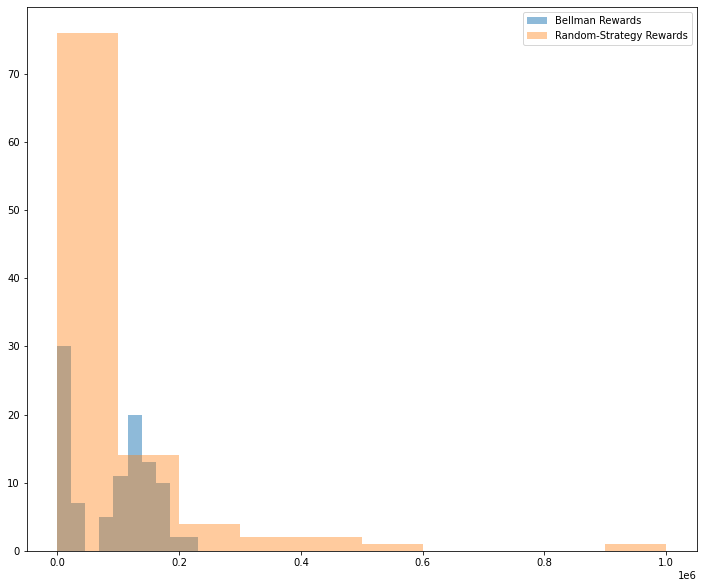

In [11]:
anls.plotRewardsDistributions()

In [12]:
print("Expected random reward: ${0:.2f}".format(np.mean(anls.randomRewardsVec)))

print("Expected Bellman reward: ${0:.2f}".format(np.mean(anls.DPrewardsVec)))

print()

print("Standard deviation random reward: ${0:.2f}".format(np.std(anls.randomRewardsVec)))
print("Standard deviation Bellman reward: ${0:.2f}".format(np.std(anls.DPrewardsVec)))



Expected random reward: $82867.09
Expected Bellman reward: $88075.65

Standard deviation random reward: $140143.68
Standard deviation Bellman reward: $68245.66
